# Regression Analysis of Bike Sharing in Seoul


**Report Contents**

1. Data description
2. Objective of the analysis
3. Data cleaning, EDA and insights
4. Feature engineering
5. Regression models
6. Final model
7. Findings and suggestions

### 1. Data description

[_The chosen dataset_](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand) contains the count of public bicycles
rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information.

Let's have a quick look at the data.

In [8]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandasql as ps
%matplotlib inline

data = pd.read_csv("../input/mysbikedataset/SeoulBikeData.csv", encoding="ISO-8859-1", engine='python')
# this data file is the same, the only difference is that columns do not include units
data.head(10)

Date  Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  \
0  01/12/2017                254     0         -5.2        37         2.2   
1  01/12/2017                204     1         -5.5        38         0.8   
2  01/12/2017                173     2         -6.0        39         1.0   
3  01/12/2017                107     3         -6.2        40         0.9   
4  01/12/2017                 78     4         -6.0        36         2.3   
5  01/12/2017                100     5         -6.4        37         1.5   
6  01/12/2017                181     6         -6.6        35         1.3   
7  01/12/2017                460     7         -7.4        38         0.9   
8  01/12/2017                930     8         -7.6        37         1.1   
9  01/12/2017                490     9         -6.5        27         0.5   

   Visibility  Dew Point Temperature  Solar Radiation  Rainfall  Snowfall  \
0        2000                  -17.6             0.00       0.0       0.0   
1        2000                  -17.6             0.00       0.0       0.0   
2        2000                  -17.7             0.00       0.0       0.0   
3        2000                  -17.6             0.00       0.0       0.0   
4        2000                  -18.6             0.00       0.0       0.0   
5        2000                  -18.7             0.00       0.0       0.0   
6        2000                  -19.5             0.00       0.0       0.0   
7        2000                  -19.3             0.00       0.0       0.0   
8        2000                  -19.8             0.01       0.0       0.0   
9        1928                  -22.4             0.23       0.0       0.0   

  Seasons     Holiday Functioning Day  
0  Winter  No Holiday             Yes  
1  Winter  No Holiday             Yes  
2  Winter  No Holiday             Yes  
3  Winter  No Holiday             Yes  
4  Winter  No Holiday             Yes  
5  Winter  No Holiday             Yes  
6  Winter  No Holiday             Yes  
7  Winter  No Holiday             Yes  
8  Winter  No Holiday             Yes  
9  Winter  No Holiday             Yes

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind Speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew Point Temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

In [10]:
data.dtypes.value_counts()

float64    6
object     4
int64      4
dtype: int64

The data has 14 columns and 4 of these are categorical.
As the column names demonstrate, there are date and time specific columns (Date, Hour, Seasons, Holiday, Functioning Day),
hourly-weather specific columns (Temperature, Humidity, Visibility, Dew Point Temperature, Solar
Radiation, Rainfall, Snowfall) and finally, the target column, Rented Bike Count. The units for the weather specific
columns can be found in the original data.

### 2. Objective of the analysis

The main goal of this analysis is to predict the total number of bikes rented, given the time and weather conditions.
To do that, first, data will be cleaned and explored. According to the data exploration step, the relationship between
the features and the target will be described and the important features will be identified for future use in
the regression analysis. Finally, the quality of the predictions will be discussed along with further recommendations.

### 3. Data cleaning, EDA and insights

#### 3.1. Data Cleaning

There are several common-sense properties of the data to be addressed. Let's start from the seasons. The relevant season
can actually be described according to the month. Instead of incorporating the column "Seasons" to the analysis,
the column "Date" can be used. Thus, the column "Seasons" will be dropped to avoid multicollinearity.

In [11]:
data = data.drop(columns=["Seasons"])

Let's continue with the dates. The column date keeps the information of day, month and year.

In [12]:
data["Date"] = pd.to_datetime(data["Date"], format='%d/%m/%Y', infer_datetime_format=True)

data["Day"] = pd.DatetimeIndex(data["Date"]).day
data["Month"] = pd.DatetimeIndex(data["Date"]).month
data["Year"] = pd.DatetimeIndex(data["Date"]).year
data.head()

Date  Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  \
0 2017-12-01                254     0         -5.2        37         2.2   
1 2017-12-01                204     1         -5.5        38         0.8   
2 2017-12-01                173     2         -6.0        39         1.0   
3 2017-12-01                107     3         -6.2        40         0.9   
4 2017-12-01                 78     4         -6.0        36         2.3   

   Visibility  Dew Point Temperature  Solar Radiation  Rainfall  Snowfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

      Holiday Functioning Day  Day  Month  Year  
0  No Holiday             Yes    1     12  2017  
1  No Holiday             Yes    1     12  2017  
2  No Holiday             Yes    1     12  2017  
3  No Holiday             Yes    1     12  2017  
4  No Holiday             Yes    1     12  2017

In [13]:
# the data is for exactly one year
ps.sqldf("select Month, COUNT (Day) / 24 "
         "from data "
         "group by Month")

Month  COUNT (Day) / 24
0       1                31
1       2                28
2       3                31
3       4                30
4       5                31
5       6                30
6       7                31
7       8                31
8       9                30
9      10                31
10     11                30
11     12                31

Since the weather changes according to the seasons within a one-year cycle, instead of a single date,
day and month information can be kept separately as two different features. To predict the bikes rented,
months and days are considered as important features to reflect the seasonality, rather than years. Additionally,
the data provides the number of bikes rented hourly in a one-year period already.
Thus, the columns _year_ and _date_ will be dropped.

But first, for feature engineering purposes, the weekdays will be also determined from the column _date_.

In [14]:
data['Weekday'] = data['Date'].apply(lambda x: pd.to_datetime(x).day_name())
data = data.drop(columns=["Year", "Date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      8760 non-null   int64  
 1   Hour                   8760 non-null   int64  
 2   Temperature            8760 non-null   float64
 3   Humidity               8760 non-null   int64  
 4   Wind Speed             8760 non-null   float64
 5   Visibility             8760 non-null   int64  
 6   Dew Point Temperature  8760 non-null   float64
 7   Solar Radiation        8760 non-null   float64
 8   Rainfall               8760 non-null   float64
 9   Snowfall               8760 non-null   float64
 10  Holiday                8760 non-null   object 
 11  Functioning Day        8760 non-null   object 
 12  Day                    8760 non-null   int64  
 13  Month                  8760 non-null   int64  
 14  Weekday                8760 non-null   object 
dtypes: f

Now, let's look at the column "Functioning Day".

In [15]:
data["Rented Bike Count"][(data["Functioning Day"] == 'No')].sum()

0

Obviously, when the bike rent service does not function during a day or an hour, bikes cannot be rented. Since
the relationship between the weather or holidays and
the functioning days is not necessarily analyzed, these rows will be eliminated with the column.

In [16]:
data = data.drop(data[data["Functioning Day"] == 'No'].index)
data = data.drop(columns=["Functioning Day"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      8465 non-null   int64  
 1   Hour                   8465 non-null   int64  
 2   Temperature            8465 non-null   float64
 3   Humidity               8465 non-null   int64  
 4   Wind Speed             8465 non-null   float64
 5   Visibility             8465 non-null   int64  
 6   Dew Point Temperature  8465 non-null   float64
 7   Solar Radiation        8465 non-null   float64
 8   Rainfall               8465 non-null   float64
 9   Snowfall               8465 non-null   float64
 10  Holiday                8465 non-null   object 
 11  Day                    8465 non-null   int64  
 12  Month                  8465 non-null   int64  
 13  Weekday                8465 non-null   object 
dtypes: float64(6), int64(6), object(2)
memory usage: 992.0+ 

#### 3.2. EDA and insights

To explore the data, relationships between several relevant features will be analyzed.

First, let's look at the pair-plots of between the features.

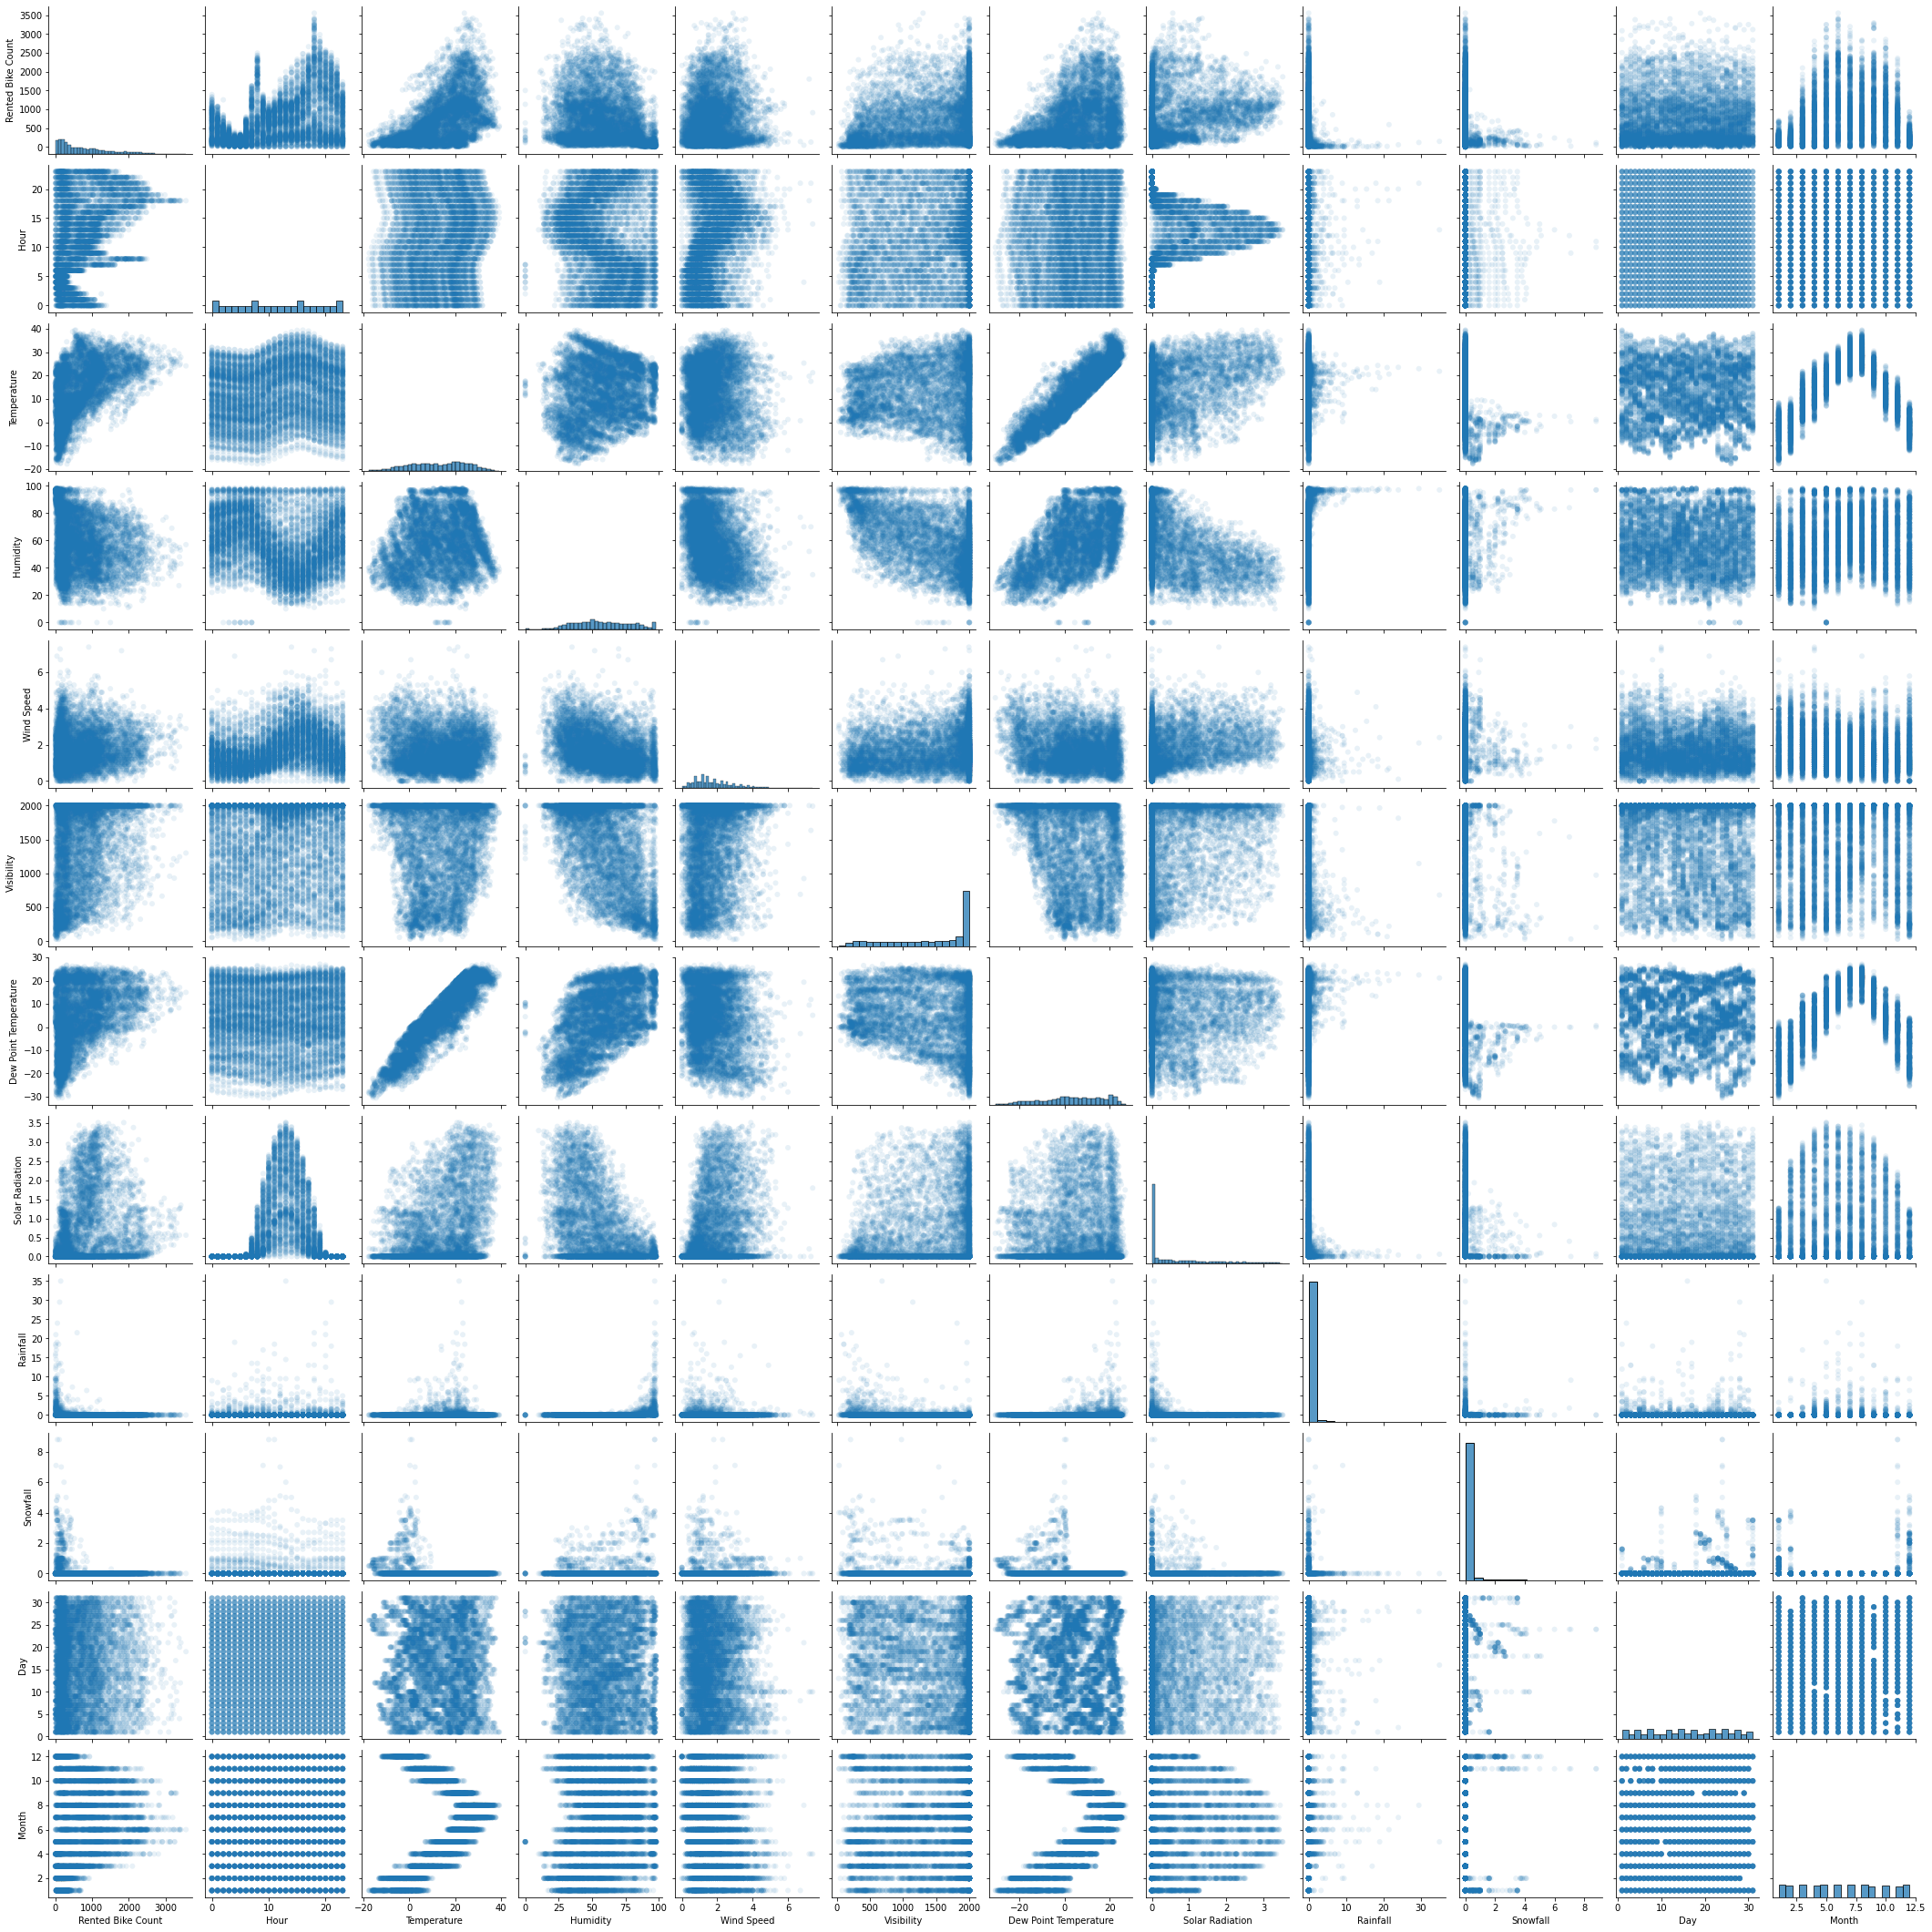

In [17]:
sns.pairplot(data, plot_kws=dict(alpha=.1, edgecolor='none'))

There are a couple of visible **non-linear** relationships between several features:

* Rented bike count - Hour
* Rented bike count - Temperature
* Rented bike count - Visibility
* Solar radiation - Hour

There can be a **linear** relationship between the **temperature** and the **dew point temperature**.

It can also be seen that there are **conditions** that make a significant difference on the target variable:
* Is it raining or not
* Is it snowing or not

Let's look at the average number of bikes rented hourly.

<AxesSubplot:xlabel='Hour', ylabel='Rented Bike Count'>

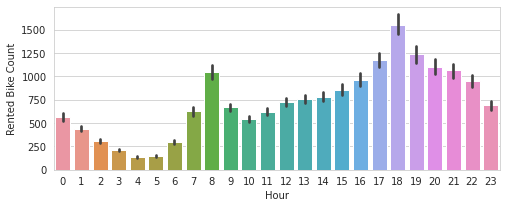

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=data, ax=ax, x="Hour", y="Rented Bike Count")

Throughout the year, it can be clearly seen that 8 AM and 6 PM are the pick points. That makes sense since people in
general goes to and comes back from work. Let's also look at the monthly activity.

<AxesSubplot:xlabel='Month', ylabel='Rented Bike Count'>

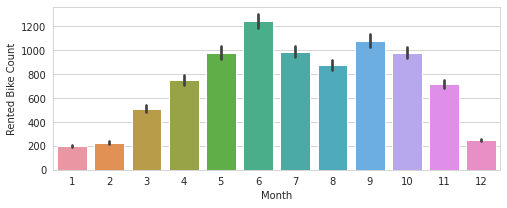

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=data, ax=ax, x="Month", y="Rented Bike Count")

Here, it is also clear that the average number of bikes rented in winter is significantly lower compared to the
other seasons.

Now, let's look at the correlation between the features _temperature_ and _dew point temperature_.

In [20]:
sp.stats.pearsonr(data["Temperature"], data["Dew Point Temperature"])[0]

0.9144669518810494

The correlation coefficient is close to 1, which points out that there is a strong positive correlation between these
features. Therefore, it can be better to get rid of one them since this correlation can be misleading
for the regression model. Let's drop the _dew point temperature_ column.

In [21]:
data = data.drop(columns=["Dew Point Temperature"])

Now, let's compare hourly average weather conditions with the average bikes rented. Since temperatures within
the same months are expected to be somewhat similar, interpreting average bikes rented according to the months makes sense.

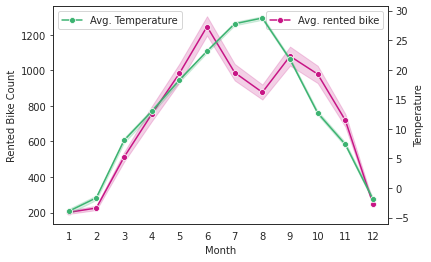

In [22]:
sns.set_style("white")
fig, ax = plt.subplots()
sns.lineplot(data=data, ax=ax, x="Month", y="Rented Bike Count", color="mediumvioletred", marker="o",
             label="Avg. rented bike")
ax2 = ax.twinx()
sns.lineplot(data=data, ax=ax2, x="Month", y="Temperature", color="mediumseagreen", marker="o",
             label="Avg. Temperature")
ax.legend(loc=1)
ax2.legend(loc=2)
ax.set_xticks(data["Month"].unique())
plt.show()

There seems to be a positive correlation between these features.

Let's look at the features _rented bike count_ and _visibility_.

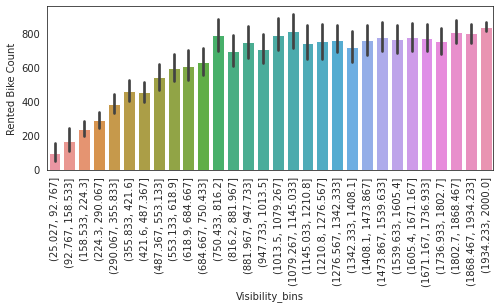

In [23]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.xticks(rotation='vertical')
data['Visibility_bins'] = pd.cut(data["Visibility"], bins=30)
sns.barplot(data=data, ax=ax, x='Visibility_bins', y='Rented Bike Count', estimator=np.mean)
data = data.drop(columns='Visibility_bins')

It can be observed that when the visibility is lower, fewer bikes are rented on average.

Let's look at the features _solar radiation_ and _hour_.

<AxesSubplot:xlabel='Hour', ylabel='Solar Radiation'>

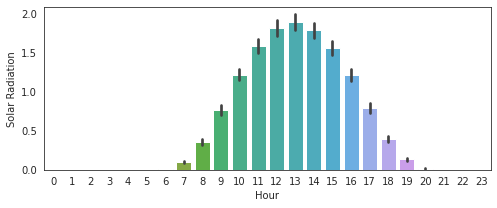

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.barplot(data=data, ax=ax, x='Hour', y='Solar Radiation')

When the hourly average number of bikes rented is interpreted, there is not a clear correlation with the solar radiation
and there are also exceptional rush hours.
The features _hour_ and _solar radiation_ have a clear non-linear relationship due to the day-and-night distinction.
Thus, rather than continues values, solar radiation can be presented with a day or night category.

### 4. Feature Engineering

#### Feature _Day_

Given dates were used to determine which day of the week it is for a specific row. Instead of using the column _day_,
using the column _weekday_ is found more reasonable, since column _day_'s numerical values may not help to identify
a meaningful relation to the target variable.

In [25]:
data = data.drop(columns=["Day"])

 Now, let's deal with the feature _solar radiation_. This feature is also updated as a categorical feature to
 avoid multicollinearity.

In [26]:
data.loc[data["Solar Radiation"] > 0.0, "Solar Radiation"] = "Day time"
data.loc[data["Solar Radiation"] == 0.0, "Solar Radiation"] = "Night time"
data.rename(columns={"Solar Radiation": "Time"})
data.head(12)

Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  Visibility  \
0                 254     0         -5.2        37         2.2        2000   
1                 204     1         -5.5        38         0.8        2000   
2                 173     2         -6.0        39         1.0        2000   
3                 107     3         -6.2        40         0.9        2000   
4                  78     4         -6.0        36         2.3        2000   
5                 100     5         -6.4        37         1.5        2000   
6                 181     6         -6.6        35         1.3        2000   
7                 460     7         -7.4        38         0.9        2000   
8                 930     8         -7.6        37         1.1        2000   
9                 490     9         -6.5        27         0.5        1928   
10                339    10         -3.5        24         1.2        1996   
11                360    11         -0.5        21         1.3        1936   

   Solar Radiation  Rainfall  Snowfall     Holiday  Month Weekday  
0       Night time       0.0       0.0  No Holiday     12  Friday  
1       Night time       0.0       0.0  No Holiday     12  Friday  
2       Night time       0.0       0.0  No Holiday     12  Friday  
3       Night time       0.0       0.0  No Holiday     12  Friday  
4       Night time       0.0       0.0  No Holiday     12  Friday  
5       Night time       0.0       0.0  No Holiday     12  Friday  
6       Night time       0.0       0.0  No Holiday     12  Friday  
7       Night time       0.0       0.0  No Holiday     12  Friday  
8         Day time       0.0       0.0  No Holiday     12  Friday  
9         Day time       0.0       0.0  No Holiday     12  Friday  
10        Day time       0.0       0.0  No Holiday     12  Friday  
11        Day time       0.0       0.0  No Holiday     12  Friday

#### Numerial Features

Let's look at the skewness of the numerical features first.

In [27]:
num_cols = data.columns[data.dtypes != object]
skew_limit = 0.75  # the limit to log transform
skew_vals = data[num_cols].skew()

# the skew columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0: 'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))
skew_cols

Skew
Rainfall           14.616921
Snowfall            8.292830
Rented Bike Count   1.139700
Wind Speed          0.894222

As implied before, the rain and snow conditions can be considered rare throughout the whole data, that's why their values are highly skewed. Since regression models will be used, the values of rain and snow that are differen than 0, may decrease the model performance by acting as outliers. Thus, it is decided to convert these features to categoricals, e.g. if it rains in a particular hour or not.

But first, the feature _wind speed_ will be transformed.

<AxesSubplot:>

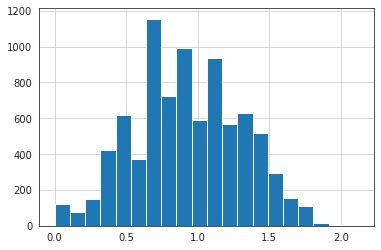

In [28]:
data["Wind Speed"].apply(np.log1p).hist(bins=20)

In [29]:
data.loc[data["Rainfall"] > 0.0, ["Rainfall"]] = "Rain"
data.loc[data["Rainfall"] == 0.0, ["Rainfall"]] = "No rain"
data.loc[data["Snowfall"] > 0.0, ["Snowfall"]] = "Snow"
data.loc[data["Snowfall"] == 0.0, ["Snowfall"]] = "No snow"

In [30]:
len(data.loc[data["Snowfall"] == "Snow"].index) # snow occurs in only 443 rows out of 8465

443

Now, let's look at the other numerical columns.

In [31]:
num_cols

Index(['Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind Speed',
       'Visibility', 'Rainfall', 'Snowfall', 'Month'],
      dtype='object')

The column _hour_ represents the periods of days. Similarly, the column _month_ represents the periods of years. Instead representing these periods with integers, categorizing them makes more sense.

In [32]:
data["Hour"] = data["Hour"].astype(str)
data["Month"] = data["Month"].astype(str)

#### Categorical Features

Let's one-hot-encode the categorical features.

In [33]:
one_hot_encode_cols = data.dtypes[data.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields
data[one_hot_encode_cols].columns

Index(['Hour', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Holiday', 'Month',
       'Weekday'],
      dtype='object')

In [34]:
data = pd.get_dummies(data, columns=one_hot_encode_cols, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rented Bike Count           8465 non-null   int64  
 1   Temperature                 8465 non-null   float64
 2   Humidity                    8465 non-null   int64  
 3   Wind Speed                  8465 non-null   float64
 4   Visibility                  8465 non-null   int64  
 5   Hour_1                      8465 non-null   uint8  
 6   Hour_10                     8465 non-null   uint8  
 7   Hour_11                     8465 non-null   uint8  
 8   Hour_12                     8465 non-null   uint8  
 9   Hour_13                     8465 non-null   uint8  
 10  Hour_14                     8465 non-null   uint8  
 11  Hour_15                     8465 non-null   uint8  
 12  Hour_16                     8465 non-null   uint8  
 13  Hour_17                     8465 

#### Target Variable

It is important for target variable to have a normal distribution when regression will be used. Let's check the distribution visually with a histogram.

<AxesSubplot:>

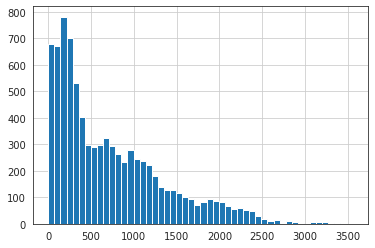

In [35]:
data["Rented Bike Count"].hist(bins=50)

From the histogram, the target variable does not seem to be normally distributed. Let's apply a normal test.

In [36]:
from scipy.stats.mstats import normaltest
normaltest(data["Rented Bike Count"].values)

NormaltestResult(statistic=1339.8474060639514, pvalue=1.1371885467443365e-291)

According to the p-value, the distribution of the target is far from normal. Preferably, a transformation (e.g. box cox)
can be applied to the target in the train sets.

Now, the data is ready for regression modeling.

### 5. Regression models

#### 5.1. K-fold Cross Validation

Data is split into 4 folds to create test tests of 25%.

In [37]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

In [38]:
data = data.reset_index(drop=True) # to avoid key error in Kfolds
X = data.drop("Rented Bike Count", axis=1)  # features
y = data["Rented Bike Count"] # target

In [39]:
kf = KFold(shuffle=True, random_state=11, n_splits=4)

In [40]:
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index, :], y[train_index], y[test_index]

These final train and test sets will be used for cross validation in the regression models.

#### 5.2. Linear Regression

The numerical columns are standardized and the model is trained with the train sets.

In [41]:
s = StandardScaler()
lr = LinearRegression()
pf = PolynomialFeatures(degree=1)

estimator = Pipeline([("scaler", s),
                      ("polynomial_features", pf),
                      ("regression", lr)])

predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)

0.724993338850279

$R^{2}$ regression score is 72% on average. To interpret the feature importances, the whole data will be used for regression exceptionally.

In [42]:
estimator.fit(X, y)
print(estimator.score(X, y))
importances = pd.DataFrame(zip(estimator.named_steps["polynomial_features"].get_feature_names_out(),
                 estimator.named_steps["regression"].coef_))
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))
col_names_dict

0.7288451119529886


{0: 'Temperature',
 1: 'Humidity',
 2: 'Wind Speed',
 3: 'Visibility',
 4: 'Hour_1',
 5: 'Hour_10',
 6: 'Hour_11',
 7: 'Hour_12',
 8: 'Hour_13',
 9: 'Hour_14',
 10: 'Hour_15',
 11: 'Hour_16',
 12: 'Hour_17',
 13: 'Hour_18',
 14: 'Hour_19',
 15: 'Hour_2',
 16: 'Hour_20',
 17: 'Hour_21',
 18: 'Hour_22',
 19: 'Hour_23',
 20: 'Hour_3',
 21: 'Hour_4',
 22: 'Hour_5',
 23: 'Hour_6',
 24: 'Hour_7',
 25: 'Hour_8',
 26: 'Hour_9',
 27: 'Solar Radiation_Night time',
 28: 'Rainfall_Rain',
 29: 'Snowfall_Snow',
 30: 'Holiday_No Holiday',
 31: 'Month_10',
 32: 'Month_11',
 33: 'Month_12',
 34: 'Month_2',
 35: 'Month_3',
 36: 'Month_4',
 37: 'Month_5',
 38: 'Month_6',
 39: 'Month_7',
 40: 'Month_8',
 41: 'Month_9',
 42: 'Weekday_Monday',
 43: 'Weekday_Saturday',
 44: 'Weekday_Sunday',
 45: 'Weekday_Thursday',
 46: 'Weekday_Tuesday',
 47: 'Weekday_Wednesday'}

In [43]:
importances.sort_values(by=1)

0             1
28  x27 -1.387006e+02
29  x28 -1.238061e+02
2    x1 -1.011825e+02
6    x5 -7.765346e+01
22  x21 -7.567040e+01
7    x6 -7.561091e+01
23  x22 -7.168901e+01
9    x8 -6.311503e+01
8    x7 -6.213374e+01
10   x9 -6.196243e+01
21  x20 -5.711677e+01
45  x44 -4.903483e+01
11  x10 -4.817142e+01
24  x23 -4.685509e+01
16  x15 -4.443856e+01
27  x26 -3.539646e+01
44  x43 -2.978071e+01
12  x11 -2.765570e+01
5    x4 -2.276571e+01
43  x42 -1.752776e+01
46  x45 -1.161000e+01
47  x46 -1.150113e+01
41  x40 -1.076295e+01
35  x34 -9.555091e+00
48  x47 -5.044299e+00
25  x24 -4.424079e+00
0     1  2.646212e-15
3    x2  2.286736e+00
20  x19  2.096275e+01
4    x3  2.156425e+01
30  x29  2.231139e+01
34  x33  2.258571e+01
13  x12  2.380110e+01
36  x35  2.409085e+01
40  x39  2.736712e+01
31  x30  2.831490e+01
37  x36  5.645351e+01
26  x25  5.659311e+01
19  x18  6.765762e+01
17  x16  7.311483e+01
15  x14  7.705945e+01
33  x32  7.996476e+01
42  x41  8.447061e+01
18  x17  8.946659e+01
38  x37  9.598603e+01
14  x13  1.167564e+02
32  x31  1.182691e+02
39  x38  1.245102e+02
1    x0  3.021633e+02

The most impactful features are:
* _solar radiation_ (day-and-night, night time specifically), _rainfall_, and _humidity_ with negative correlation
* _months_ 6 and 10, and _temperature_ with positive correlation.

The results make sense according to EDA. When the weather is warmer, the number of rented bikes are also higher. Within daytime, people are more likely to rent a bike when compared to nighttime. If the weather is not rainy, it is more likely to see a higher amount of bikes rented. Interestingly, snowy weather has a small positive coefficient in this case.

#### 5.3. Polynomial Regression

To get results faster, only degrees 2 and 3 are used.

In [44]:
s = StandardScaler()
lr = LinearRegression()
pf = PolynomialFeatures(degree=2)

estimator = Pipeline([("scaler", s),
                      ("polynomial_features", pf),
                      ("regression", lr)])

predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)

-6.582571857417235e+22

In [45]:
s = StandardScaler()
lr = LinearRegression()
pf = PolynomialFeatures(degree=3)

estimator = Pipeline([("scaler", s),
                      ("polynomial_features", pf),
                      ("regression", lr)])

predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)

-5.815466467984974e+19

$R^{2}$ regression score is a very large negative number for both of the models, which points out that the models perform very poorly.

#### 5.4. Ridge Regression

For Ridge regression, several alpha parameters and also polynomial degrees are considered. Grid search is used to find the best parameters.


In [46]:
from sklearn.model_selection import GridSearchCV

estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(0.01, 20, 10)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [47]:
grid.fit(X, y)
grid.best_score_, grid.best_params_

(0.9025557185072092,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 20.0})

In [48]:
y_predict = grid.predict(X)
r2_score(y, y_predict)

0.9262329209982423

$R^{2}$ regression score is nearly 93%, which means the model performs better with regularization. Also, it can be seen that the best model includes polynomial features degree of 2. Best alpha parameter (lambda) is also 20, a considerately large coefficient for penalty. This can be implying that there is a need to penalize more and shrink more some regression coefficients.

#### 5.5. Random Forest Regression

Random forest regression is also known for performing well. Let's try it out.

In [49]:
from sklearn.ensemble import RandomForestRegressor

s = StandardScaler()
rf = RandomForestRegressor()
pf = PolynomialFeatures(degree=1)

estimator = Pipeline([("scaler", s),
                      ("polynomial_features", pf),
                      ("regression", rf)])

predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)

0.8947252410484603

$R^{2}$ regression score is 90%. Random forest regression has outperformed the base linear regression model. However, Ridge regression seems to perform better for this particular data.

### 6. Final Model

If the regression models are evaluated according to their $R^{2}$ regression scores, Ridge regression has outperformed the other models with the parameters lambda=20 and polynomial degree of 2. Cross validation is also used to create various train and test cases. Therefore, this particular model can be used to predict the number of bikes to be rented when the weather and time conditions are provided.

Let's now look at the regression coefficients of the recommended Ridge regression model.

In [50]:
np.set_printoptions(threshold=np.inf)
sorted(grid.best_estimator_.named_steps['ridge_regression'].coef_)

df_importances = pd.DataFrame(zip(grid.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(),
                 grid.best_estimator_.named_steps["ridge_regression"].coef_,
))
df_importances.sort_values(by=1)

0           1
2          x1  -99.228383
49       x0^2  -92.845345
97       x1^2  -88.030027
76     x0 x27  -68.060973
968   x25 x44  -64.831398
...       ...         ...
1189    x40^2   81.721810
1          x0   83.995910
85     x0 x36   93.598116
80     x0 x31  122.748744
90     x0 x41  126.327613

[1225 rows x 2 columns]

Since polynomial features are used, there are numerous coefficients, including the intersection terms. Top and bottom 5 are interpreted in the next section.

### 7. Findings and suggestions

Regularization with Ridge performed quite well, so did Random Forest. However, Random Forest regression can be more risky than Ridge regression since Ridge is expected to avoid overfitting. That was also one of the reasons to suggest Ridge as the final model.

Several weather conditions, dates, and times are proved to be affecting the number of bikes rented. To interpret the
most impactful features, similarities to the base linear regression model can be seen.
For example, the temperature is powerful alone and also together with several other features, e.g. months June and October.
Humidity is also impactful, but it has a negative relationship with the target variable. Since polynomial features are allowed, the relationship between the hours and weekdays is also appeared to be significant, e.g. Sunday and Hour 8. It is less likely for people to get up early on Sundays.
Also stated in the EDA part, these coefficients found by the final model seem to be reasonable and accountable.
People would definitely consider the time and weather before they rent bikes to avoid difficult situations as they are exposed to weather conditions for sure while riding a bike.

To improve the model performance, a transformation to the target variable can be added. In that case, train sets for the target and the predictions must be transformed. Also, in the feature engineering part, a lot of assumptions are made according to the EDA, however, different paths of feature engineering are also couraged since the input data is significant for models to work accurately.

_by Sude Kocaçiftçi Bayraktar_
